# LORA Finetune invoice classification model

In [1]:
import numpy as np
import torch
import mlflow
from datasets import load_from_disk, load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model

from src.config import init_config, config_to_container
from src.metrics import compute_metrics, cfm_metric
from src.visuals import plot_confusion_matrix

## Config and settings

In [2]:
LORA_SIZE = "small"

In [3]:
config = init_config(overrides=["+train=LORA", F"+lora={LORA_SIZE}"], resolve=True)

In [4]:
print(config)

data:
  fatura: mathieu1256/FATURA2-invoices
  rvl_cdip_subset: jinhybr/rvl_cdip_400_train_val_test
  invoiceXpert:
    hf_path: wiF0n/InvoiceXpert
    local_path: data/invoiceXpert
    num_labels: 2
    label_col: label
    image_col: image
    label_names:
    - invoice
    - not-invoice
models:
  classification:
    oob:
      pt: microsoft/dit-base
      ft: microsoft/dit-base-finetuned-rvlcdip
mlflow:
  experiments:
    classification: invoice-classification
utils:
  seed: 420
  run_date: 2024-17-02/24/24
train:
  output_dir: ./models/LORA_ft
  overwrite_output_dir: true
  do_train: true
  do_eval: true
  evaluation_strategy: steps
  eval_steps: 50
  num_train_epochs: 3
  per_device_train_batch_size: 64
  per_device_eval_batch_size: 64
  learning_rate: 5.0e-05
  logging_strategy: steps
  logging_steps: 5
  save_strategy: steps
  save_total_limit: 1
  bf16: true
  dataloader_num_workers: 4
  load_best_model_at_end: true
  report_to: mlflow
  remove_unused_columns: false
  label_nam

In [5]:
experiment = mlflow.set_experiment(config.mlflow.experiments.classification)

## Load the model

In [6]:
image_processor = AutoImageProcessor.from_pretrained(config.models.classification.oob.pt)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/home/david/code/InvoiceXpert/.venv/lib/python3.10/site-packages/transformers/models/beit/image_processing_beit.py:111: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
model = AutoModelForImageClassification.from_pretrained(config.models.classification.oob.pt, num_labels=2, ignore_mismatched_sizes=True)
lora_config = LoraConfig(
    **config_to_container(config.lora)
)
model = get_peft_model(model, lora_config)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
num_trainable_params, num_all_params = model.get_nb_trainable_parameters()
model_params_dict = {
    "num_trainable_model_params": num_trainable_params,
    "num_all_model_params": num_all_params,
    "pct_trainable_model_params": 100*(num_trainable_params / num_all_params)
}

In [9]:
print("All parameters:", model_params_dict["num_all_model_params"])
print("Trainable parameters:", model_params_dict["num_trainable_model_params"])
print("Percentage of trainable parameters:", model_params_dict["pct_trainable_model_params"])

All parameters: 86991364
Trainable parameters: 1181186
Percentage of trainable parameters: 1.3578198405993496


## Load and preprocess the data

In [10]:
invoice_df = load_from_disk(config.data.invoiceXpert.local_path, keep_in_memory=True)

In [11]:
def preprocess_function(examples):
    examples["pixel_values"] = image_processor(examples["image"], return_tensors="pt")["pixel_values"]
    del examples["image"]
    return examples

In [12]:
prepped_df = invoice_df.with_transform(preprocess_function)

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Trainer

In [14]:
training_args = TrainingArguments(**config_to_container(config.train))

In [15]:
run = mlflow.start_run(experiment_id=experiment.experiment_id, run_name=F"dit-base-invoiceXpert-LORA-{LORA_SIZE}-ft")

In [16]:
mlflow.log_params(model_params_dict)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepped_df["train"],
    eval_dataset=prepped_df["validation"],
    compute_metrics=compute_metrics,
    # Has to create collate function with PEFT
    # and add `label_names` to the training arguments
    data_collator=collate_fn,
)

In [18]:
trainer.train()
trainer.save_model()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.611500,0.581087,0.619687,0.324264,0.970100,0.194667
100,0.455100,0.393937,0.778750,0.698210,0.968085,0.546000
150,0.262000,0.197553,0.953750,0.950961,0.945323,0.956667
200,0.117400,0.109326,0.965625,0.964332,0.938763,0.991333
250,0.127200,0.101772,0.968125,0.966926,0.941288,0.994000
300,0.099400,0.099167,0.968125,0.966840,0.943528,0.991333
350,0.099000,0.098349,0.968125,0.966775,0.945223,0.989333
400,0.131700,0.097623,0.969375,0.968161,0.944233,0.993333
450,0.115900,0.097190,0.970000,0.968831,0.944304,0.994667
500,0.131600,0.096930,0.970000,0.968851,0.943742,0.995333


Checkpoint destination directory ./models/LORA_ft/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


In [19]:
trainer.evaluate()

{'eval_loss': 0.09692972153425217,
 'eval_accuracy': 0.97,
 'eval_f1': 0.9688513951979234,
 'eval_precision': 0.9437420986093552,
 'eval_recall': 0.9953333333333333,
 'eval_runtime': 13.3816,
 'eval_samples_per_second': 239.134,
 'eval_steps_per_second': 3.736,
 'epoch': 3.0}

In [20]:
trainer.evaluate(eval_dataset=prepped_df["test"], metric_key_prefix="test")

{'test_loss': 0.1017579585313797,
 'test_accuracy': 0.9656666666666667,
 'test_f1': 0.966612641815235,
 'test_precision': 0.9406940063091482,
 'test_recall': 0.994,
 'test_runtime': 12.9673,
 'test_samples_per_second': 231.351,
 'test_steps_per_second': 3.625,
 'epoch': 3.0}

In [21]:
eval_preds = trainer.predict(prepped_df["validation"])
test_preds = trainer.predict(prepped_df["test"])

In [22]:
eval_cfm = cfm_metric.compute(references=eval_preds.label_ids, predictions=np.argmax(eval_preds.predictions, axis=-1))["confusion_matrix"]
test_cfm = cfm_metric.compute(references=test_preds.label_ids, predictions=np.argmax(test_preds.predictions, axis=-1))["confusion_matrix"]

Confusion matrix, without normalization
[[1611   89]
 [   7 1493]]


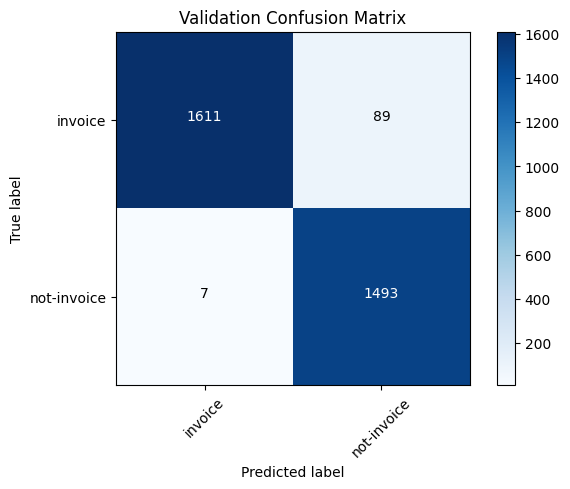

In [23]:
eval_cfm_plot = plot_confusion_matrix(eval_cfm, classes=config.data.invoiceXpert.label_names, title="Validation Confusion Matrix")

Confusion matrix, without normalization
[[1406   94]
 [   9 1491]]


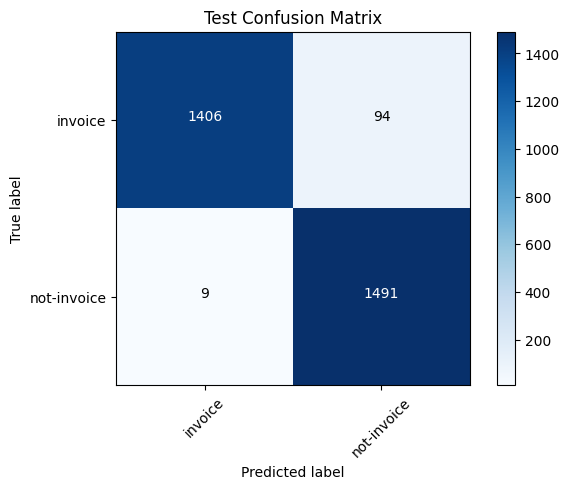

In [24]:
test_cfm_plot = plot_confusion_matrix(test_cfm, classes=config.data.invoiceXpert.label_names, title="Test Confusion Matrix")

In [25]:
mlflow.log_figure(eval_cfm_plot, "validation_confusion_matrix.png")
mlflow.log_figure(test_cfm_plot, "test_confusion_matrix.png")

In [26]:
mlflow.end_run()